# Solving a Fourth Order Elliptic Singular Perturbation Problem

$$
\left\{\begin{array}{lr}
\varepsilon^{2} \Delta^{2} u-\Delta u=f & \text { in } \Omega \\
u=\partial_{n} u=0 & \text { on } \partial \Omega
\end{array}\right.
$$

In [1]:
from skfem import *
import numpy as np
from skfem.visuals.matplotlib import draw, plot
from skfem.utils import solver_iter_krylov
from skfem.helpers import d, dd, ddd, dot, ddot, grad, dddot, prod
from scipy.sparse.linalg import LinearOperator, minres
from skfem import *
from skfem.models.poisson import *
from skfem.assembly import BilinearForm, LinearForm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
plt.rcParams['figure.dpi'] = 200

pi = np.pi
sin = np.sin
cos = np.cos
exp = np.exp

## Problem1

The modified Morley-Wang-Xu element method is equivalent to finding $w_{h} \in W_{h}$ and $u_{h 0} \in V_{h 0}$ such that
$$
\begin{aligned}
\left(\nabla w_{h}, \nabla \chi_{h}\right) &=\left(f, \chi_{h}\right) & & \forall \chi_{h} \in W_{h} \\
\varepsilon^{2} a_{h}\left(u_{h 0}, v_{h}\right)+b_{h}\left(u_{h 0}, v_{h}\right) &=\left(\nabla w_{h}, \nabla_{h} v_{h}\right) & & \forall v_{h} \in V_{h 0}
\end{aligned}
$$
where 
$$
a_{h}\left(u_{h 0}, v_{h}\right):=\left(\nabla_{h}^{2} u_{h 0}, \nabla_{h}^{2} v_{h}\right), \quad b_{h}\left(u_{h 0}, v_{h}\right):=\left(\nabla_{h} u_{h 0}, \nabla_{h} v_{h}\right)
$$

## Problem2

The modified Morley-Wang-Xu element method is also equivalent to
$$
\begin{aligned}
\left(\nabla w_{h}, \nabla \chi_{h}\right) &=\left(f, \chi_{h}\right) & & \forall \chi_{h} \in W_{h} \\
\varepsilon^{2} \tilde{a}_{h}\left(u_{h}, v_{h}\right)+b_{h}\left(u_{h}, v_{h}\right) &=\left(\nabla w_{h}, \nabla_{h} v_{h}\right) & & \forall v_{h} \in V_{h}
\end{aligned}
$$
where
$$
\tilde{a}_{h}\left(u_{h}, v_{h}\right):=\left(\nabla_{h}^{2} u_{h}, \nabla_{h}^{2} v_{h}\right)-\sum_{F \in \mathcal{F}_{h}^{\partial}}\left(\partial_{n n}^{2} u_{h}, \partial_{n} v_{h}\right)_{F}-\sum_{F \in \mathcal{F}_{h}^{\partial}}\left(\partial_{n} u_{h}, \partial_{n n}^{2} v_{h}\right)_{F}+\sum_{F \in \mathcal{F}_{h}^{\partial}} \frac{\sigma}{h_{F}}\left(\partial_{n} u_{h}, \partial_{n} v_{h}\right)_{F}
$$

## Forms and errors

In [2]:
@Functional
def L2uError(w):
    x, y = w.x
    return (w.w - exact_u(x, y))**2


def get_DuError(basis, u):
    duh = basis.interpolate(u).grad
    x = basis.global_coordinates().value
    dx = basis.dx  # quadrature weights
    dux, duy = dexact_u(x[0], x[1])
    return np.sqrt(np.sum(((duh[0] - dux)**2 + (duh[1] - duy)**2) * dx))


def get_D2uError(basis, u):
    dduh = basis.interpolate(u).hess
    x = basis.global_coordinates(
    ).value  # coordinates of quadrature points [x, y]
    dx = basis.dx  # quadrature weights
    duxx, duxy, duyx, duyy = ddexact(x[0], x[1])
    return np.sqrt(
        np.sum(((dduh[0][0] - duxx)**2 + (dduh[0][1] - duxy)**2 +
                (dduh[1][1] - duyy)**2 + (dduh[1][0] - duyx)**2) * dx))


@BilinearForm
def a_load(u, v, w):
    '''
    for $a_{h}$
    '''
    return ddot(dd(u), dd(v))


@BilinearForm
def b_load(u, v, w):
    '''
    for $b_{h}$
    '''
    return dot(grad(u), grad(v))


@BilinearForm
def wv_load(u, v, w):
    '''
    for $(\nabla \chi_{h}, \nabla_{h} v_{h})$
    '''
    return dot(grad(u), grad(v))


@BilinearForm
def penalty_1(u, v, w):
    return ddot(-dd(u), prod(w.n, w.n)) * dot(grad(v), w.n)

@BilinearForm
def penalty_2(u, v, w):
    return ddot(-dd(v), prod(w.n, w.n)) * dot(grad(u), w.n) 


@BilinearForm
def penalty_3(u, v, w):
    global mem
    global nn
    global memu
    nn = prod(w.n, w.n)
    mem = w
    memu = u
    return (sigma / w.h) * dot(grad(u), w.n) * dot(grad(v), w.n) 


@BilinearForm
def laplace(u, v, w):
    '''
    for $(\nabla w_{h}, \nabla \chi_{h})$
    '''
    return dot(grad(u), grad(v))

## Solver for problem1

In [3]:
def easy_boundary(basis):
    '''
    Input basis
    ----------------
    Return D for boundary conditions
    '''

    dofs = basis.find_dofs({
        'left': m.facets_satisfying(lambda x: x[0] == 0),
        'right': m.facets_satisfying(lambda x: x[0] == 1),
        'top': m.facets_satisfying(lambda x: x[1] == 1),
        'buttom': m.facets_satisfying(lambda x: x[1] == 0)
    })

    D = np.concatenate((dofs['left'].nodal['u'], dofs['right'].nodal['u'],
                        dofs['top'].nodal['u'], dofs['buttom'].nodal['u'],
                        dofs['left'].facet['u_n'], dofs['right'].facet['u_n'],
                        dofs['top'].facet['u_n'], dofs['buttom'].facet['u_n']))
    return D


def solve_problem1(m):

    element = {'w': ElementTriP2(), 'u': ElementTriMorley()}
    basis = {
        variable: InteriorBasis(m, e, intorder=4)
        for variable, e in element.items()
    }  # intorder: integration order for quadrature

    K1 = asm(laplace, basis['w'])
    f1 = asm(f_load, basis['w'])

    wh = solve(*condense(K1, f1, D=m.boundary_nodes()),
               solver=solver_iter_krylov(Precondition=True, tol=1e-8))

    K2 = epsilon**2 * asm(a_load, basis['u']) + asm(b_load, basis['u'])
    f2 = asm(wv_load, basis['w'], basis['u']) * wh
    uh0 = solve(*condense(K2, f2, D=easy_boundary(basis['u'])),
                solver=solver_iter_krylov(Precondition=True))  # cg
    return uh0, basis

## Solver for problem2

In [4]:
def easy_boundary_penalty(basis):
    '''
    Input basis
    ----------------
    Return D for boundary conditions
    '''

    dofs = basis.find_dofs({
        'left': m.facets_satisfying(lambda x: x[0] == 0),
        'right': m.facets_satisfying(lambda x: x[0] == 1),
        'top': m.facets_satisfying(lambda x: x[1] == 1),
        'buttom': m.facets_satisfying(lambda x: x[1] == 0)
    })

    D = np.concatenate((dofs['left'].nodal['u'], dofs['right'].nodal['u'],
                        dofs['top'].nodal['u'], dofs['buttom'].nodal['u']))
    return D


def solve_problem2(m):
    global fbasis
    global wh
    element = {'w': ElementTriP2(), 'u': ElementTriMorley()}
    basis = {
        variable: InteriorBasis(m, e, intorder=4)
        for variable, e in element.items()
    }

    K1 = asm(laplace, basis['w'])
    f1 = asm(f_load, basis['w'])

    wh = solve(*condense(K1, f1, D=m.boundary_nodes()),
               solver=solver_iter_krylov(Precondition=True))
    
    fbasis = FacetBasis(m, element['u'])
    
    p1 = asm(penalty_1, fbasis)
    p2 = asm(penalty_2, fbasis)
    p3 = asm(penalty_3, fbasis)
    P = p1 + p2 + p3

    K2 = epsilon**2 * asm(a_load, basis['u']) + epsilon**2 * P + asm(b_load, basis['u'])
    f2 = asm(wv_load, basis['w'], basis['u']) * wh
    uh0 = solve(*condense(K2, f2, D=easy_boundary_penalty(basis['u'])), solver=solver_iter_krylov(Precondition=True))  
    # uh0 = solve(*condense(K2 + P, f2, D=m.boundary_nodes()), solver=solver_iter_krylov(Precondition=True)) 
    return uh0, basis


# Numerical results
> setting boundary condition: $u=0 \ on \ \partial \Omega$

## Parameters 
$$
\tilde{a}_{h}\left(u_{h}, v_{h}\right):=\left(\nabla_{h}^{2} u_{h}, \nabla_{h}^{2} v_{h}\right)-\sum_{F \in \mathcal{F}_{h}^{\partial}}\left(\partial_{n n}^{2} u_{h}, \partial_{n} v_{h}\right)_{F}-\sum_{F \in \mathcal{F}_{h}^{\partial}}\left(\partial_{n} u_{h}, \partial_{n n}^{2} v_{h}\right)_{F}+\sum_{F \in \mathcal{F}_{h}^{\partial}} \frac{\sigma}{h_{F}}\left(\partial_{n} u_{h}, \partial_{n} v_{h}\right)_{F}
$$


- `sigma` in $\sum_{F \in \mathcal{F}_{h}^{\partial}} \frac{\sigma}{h_{F}}\left(\partial_{n} u_{h}, \partial_{n} v_{h}\right)_{F}$

## Example 1
$$
u\left(x_{1}, x_{2}\right)=\left(\sin \left(\pi x_{1}\right) \sin \left(\pi x_{2}\right)\right)^{2}
$$

In [64]:
@LinearForm
def f_load(v, w):
    '''
    for $(f, x_{h})$
    '''
    pix = pi * w.x[0]
    piy = pi * w.x[1]
    lu = 2 * (pi)**2 * (cos(2 * pix) * ((sin(piy))**2) + cos(2 * piy) *
                        ((sin(pix))**2))
    llu = -8 * (pi)**4 * (cos(2 * pix) * sin(piy)**2 + cos(2 * piy) *
                          sin(pix)**2 - cos(2 * pix) * cos(2 * piy))
    return (epsilon**2 * llu - lu) * v


def exact_u(x, y):
    return (sin(pi * x) * sin(pi * y))**2


def dexact_u(x, y):
    dux = 2 * pi * cos(pi * x) * sin(pi * x) * sin(pi * y)**2
    duy = 2 * pi * cos(pi * y) * sin(pi * x)**2 * sin(pi * y)
    return dux, duy


def ddexact(x, y):
    duxx = 2 * pi**2 * cos(pi * x)**2 * sin(pi * y)**2 - 2 * pi**2 * sin(
        pi * x)**2 * sin(pi * y)**2
    duxy = 2 * pi * cos(pi * x) * sin(pi * x) * 2 * pi * cos(pi * y) * sin(
        pi * y)
    duyx = duxy
    duyy = 2 * pi**2 * cos(pi * y)**2 * sin(pi * x)**2 - 2 * pi**2 * sin(
        pi * y)**2 * sin(pi * x)**2
    return duxx, duxy, duyx, duyy

### Without penalty (Problem1)

In [65]:
refine_time = 6
epsilon_range = 3
for j in range(epsilon_range):
    epsilon = 1 * 10**(-j*2)

    L2_list = []
    Du_list = []
    D2u_list = []
    h_list = []
    epu_list = []
    m = MeshTri()

    for i in range(1, refine_time+1):
        
        m.refine()
        uh0, basis = solve_problem1(m)
        U = basis['u'].interpolate(uh0).value

        L2u = np.sqrt(L2uError.assemble(basis['u'], w=U))
        Du = get_DuError(basis['u'], uh0)
        H1u = Du + L2u
        D2u = get_D2uError(basis['u'], uh0)
        H2u = Du + L2u + D2u
        epu = np.sqrt(epsilon**2 * D2u**2 + Du**2)
        h_list.append(m.param())
        Du_list.append(Du)
        L2_list.append(L2u)
        D2u_list.append(D2u)
        epu_list.append(epu)
        
    hs = np.array(h_list)
    L2s = np.array(L2_list)
    Dus = np.array(Du_list)
    D2us = np.array(D2u_list)
    epus = np.array(epu_list)
    H1s = L2s + Dus
    H2s = H1s + D2us
    print('epsilon =', epsilon)
    print('  h    L2u   H1u   H2u   epu')
    for i in range(H2s.shape[0] - 1):
        print(
            '2^-' + str(i + 2), ' {:.2f}  {:.2f}  {:.2f}  {:.2f}'.format(
                -np.log2(L2s[i + 1] / L2s[i]), -np.log2(H1s[i + 1] / H1s[i]),
                -np.log2(H2s[i + 1] / H2s[i]),
                -np.log2(epus[i + 1] / epus[i])))
#         print(
#             '2^-' + str(i + 2), ' {:.5f}  {:.5f}  {:.5f}  {:.5f}'.format(
#                 L2s[i + 1], H1s[i + 1],
#                 H2s[i + 1],
#                 epus[i + 1]))
        
uh0_no_penalty = uh0

epsilon = 1
  h    L2u   H1u   H2u   epu
2^-2  1.79  0.91  0.69  0.67
2^-3  2.19  1.76  1.02  0.98
2^-4  2.16  1.93  1.05  1.02
2^-5  2.06  1.98  1.02  1.01
2^-6  2.02  2.00  1.01  1.00
epsilon = 0.01
  h    L2u   H1u   H2u   epu
2^-2  1.43  0.77  0.45  0.70
2^-3  2.26  1.67  0.86  1.61
2^-4  2.08  1.94  1.09  1.86
2^-5  1.76  2.03  1.22  1.85
2^-6  1.82  2.02  1.14  1.59
epsilon = 0.0001
  h    L2u   H1u   H2u   epu
2^-2  1.43  0.77  0.45  0.70
2^-3  2.29  1.66  0.81  1.61
2^-4  2.31  1.89  0.94  1.87
2^-5  2.14  1.97  0.98  1.96
2^-6  2.04  1.99  1.00  1.99


### With penalty (Problem2)

In [66]:
sigma = 5
for j in range(epsilon_range):
    epsilon = 1 * 10**(-j * 2)
    ep = epsilon
    L2_list = []
    Du_list = []
    D2u_list = []
    h_list = []
    epu_list = []
    m = MeshTri()

    for i in range(1, refine_time + 1):

        m.refine()
        uh0, basis = solve_problem2(m)
        U = basis['u'].interpolate(uh0).value

        L2u = np.sqrt(L2uError.assemble(basis['u'], w=U))
        Du = get_DuError(basis['u'], uh0)
        H1u = Du + L2u
        D2u = get_D2uError(basis['u'], uh0)
        H2u = Du + L2u + D2u
        epu = np.sqrt(epsilon**2 * D2u**2 + Du**2)
        h_list.append(m.param())
        Du_list.append(Du)
        L2_list.append(L2u)
        D2u_list.append(D2u)
        epu_list.append(epu)

    hs = np.array(h_list)
    L2s = np.array(L2_list)
    Dus = np.array(Du_list)
    D2us = np.array(D2u_list)
    epus = np.array(epu_list)
    H1s = L2s + Dus
    H2s = H1s + D2us

    print('epsilon =', epsilon)
    print('  h    L2u   H1u   H2u   epu')
    for i in range(H2s.shape[0] - 1):
        print(
            '2^-' + str(i + 2), ' {:.2f}  {:.2f}  {:.2f}  {:.2f}'.format(
                -np.log2(L2s[i + 1] / L2s[i]), -np.log2(H1s[i + 1] / H1s[i]),
                -np.log2(H2s[i + 1] / H2s[i]),
                -np.log2(epus[i + 1] / epus[i])))
        
#         print(
#             '2^-' + str(i + 2),
#             ' {:.5f}  {:.5f}  {:.5f}  {:.5f}'.format(L2s[i + 1], H1s[i + 1],
#                                                      H2s[i + 1], epus[i + 1]))

uh0_penalty = uh0

epsilon = 1
  h    L2u   H1u   H2u   epu
2^-2  1.67  0.87  0.70  0.69
2^-3  2.26  1.80  1.07  1.02
2^-4  2.24  1.95  1.04  1.01
2^-5  2.12  1.99  1.02  1.00
2^-6  2.04  2.00  1.01  1.00
epsilon = 0.01
  h    L2u   H1u   H2u   epu
2^-2  1.25  0.59  0.21  0.51
2^-3  2.31  1.56  0.69  1.48
2^-4  2.24  1.90  0.98  1.79
2^-5  1.85  2.18  1.36  1.95
2^-6  1.83  2.20  1.46  1.80
epsilon = 0.0001
  h    L2u   H1u   H2u   epu
2^-2  1.24  0.58  0.20  0.50
2^-3  2.30  1.50  0.60  1.45
2^-4  2.37  1.67  0.66  1.65
2^-5  2.23  1.66  0.62  1.65
2^-6  2.11  1.61  0.58  1.60


In [79]:
# mem.n[1][mem.x[0] == 0]  # ny when x = 0

# mem.n[0][mem.x[0]==0] # nx when x = 0

# mem.n[0][mem.x[0]==1] # nx when x = 1

# mem.n[1][mem.x[1]==1] # ny when y = 1

# plot(basis['u'], uh0_penalty-uh0_no_penalty, colorbar=True)

# # x = basis['u'].doflocs[0]
# # y = basis['u'].doflocs[1]
# # u = exact_u(x, y)

# # plot(basis['u'], u-uh0_penalty, colorbar = True)

# # # uh0_penalty[m.boundary_nodes()]

# # m = MeshTri()
# # m.refine(refine_time)

# # # fbasis_dof = FacetBasis(m,
# # #                     ElementTriMorley())

# # fbasis_dof = FacetBasis(m,
# #                     ElementTriMorley(),
# #                     quadrature=(np.array([[0.0, 0.5, 1.0]]), np.array(
# #                         [1, 1, 1])))  # quadrature: points and weights

# # p3 = asm(penalty_3, fbasis_dof)

# $\partial u_{n}$ of `uh0_without_penalty` on boundary nodes

# Data structure: $[n1, n2, n3]$ for each facet

# - $n1, n3$ : $\partial u_{n}$ on two ends of a facet

# - $n2$ : $\partial u_{n}$ on the middle point of a facet

# # dot(fbasis_dof.interpolate(uh0_no_penalty).grad, mem.n)

# $\partial u_{n}$ of `uh0_penalty` on boundary nodes

# # dot(fbasis_dof.interpolate(uh0_penalty).grad, mem.n)

# # # ### Showing examples of facets used in caculating penalty and also $\partial u_{n}$

# # # for i in [0,8]:
# # #     plt.scatter(mem.x[0][i], mem.x[1][i], s=4, marker='*')
# # #     plt.axis('square')

## Example 2

$$
u=g(x)p(y)
$$
where
$$
g(x)=\frac{1}{2}\left[\sin (\pi x)+\frac{\pi \varepsilon}{1-e^{-1 / \varepsilon}}\left(e^{-x / \varepsilon}+e^{(x-1) / \varepsilon}-1-e^{-1 / \varepsilon}\right)\right]
$$
$$
p(y)=2 y\left(1-y^{2}\right)+\varepsilon\left[l d(1-2 y)-3 \frac{q}{l}+\left(\frac{3}{l}-d\right) e^{-y / \varepsilon}+\left(\frac{3}{l}+d\right) e^{(y-1) / \varepsilon}\right]
$$
$$
l=1-e^{-1 / \varepsilon}, q=2-l \text { and } d=1 /(q-2 \varepsilon l)
$$

In [72]:
@LinearForm
def f_load(v, w):
    '''
    for $(f, x_{h})$
    '''
    x = w.x[0]
    y = w.x[1]
    return (
        (sin(pi * x) / 2 - (ep * pi * (exp(-x / ep) + exp(
            (x - 1) / ep) - exp(-1 / ep) - 1)) / (2 * (exp(-1 / ep) - 1))) *
        (12 * y + ep *
         ((exp(-y / ep) *
           (3 / (exp(-1 / ep) - 1) + 1 /
            (exp(-1 / ep) + 2 * ep * (exp(-1 / ep) - 1) + 1))) / ep**2 + (exp(
                (y - 1) / ep) * (3 / (exp(-1 / ep) - 1) - 1 /
                                 (exp(-1 / ep) + 2 * ep *
                                  (exp(-1 / ep) - 1) + 1))) / ep**2)) -
        ((pi**2 * sin(pi * x)) / 2 + (ep * pi * (exp(-x / ep) / ep**2 + exp(
            (x - 1) / ep) / ep**2)) / (2 * (exp(-1 / ep) - 1))) *
        (ep * (exp((y - 1) / ep) * (3 / (exp(-1 / ep) - 1) - 1 /
                                    (exp(-1 / ep) + 2 * ep *
                                     (exp(-1 / ep) - 1) + 1)) + exp(-y / ep) *
               (3 / (exp(-1 / ep) - 1) + 1 /
                (exp(-1 / ep) + 2 * ep *
                 (exp(-1 / ep) - 1) + 1)) - (3 * exp(-1 / ep) + 3) /
               (exp(-1 / ep) - 1) - ((2 * y - 1) * (exp(-1 / ep) - 1)) /
               (exp(-1 / ep) + 2 * ep * (exp(-1 / ep) - 1) + 1)) + 2 * y *
         (y**2 - 1)) - ep**2 *
        (((pi**4 * sin(pi * x)) / 2 - (ep * pi * (exp(-x / ep) / ep**4 + exp(
            (x - 1) / ep) / ep**4)) / (2 * (exp(-1 / ep) - 1))) *
         (ep * (exp((y - 1) / ep) * (3 / (exp(-1 / ep) - 1) - 1 /
                                     (exp(-1 / ep) + 2 * ep *
                                      (exp(-1 / ep) - 1) + 1)) + exp(-y / ep) *
                (3 / (exp(-1 / ep) - 1) + 1 /
                 (exp(-1 / ep) + 2 * ep *
                  (exp(-1 / ep) - 1) + 1)) - (3 * exp(-1 / ep) + 3) /
                (exp(-1 / ep) - 1) - ((2 * y - 1) * (exp(-1 / ep) - 1)) /
                (exp(-1 / ep) + 2 * ep * (exp(-1 / ep) - 1) + 1)) + 2 * y *
          (y**2 - 1)) - 2 *
         (12 * y + ep *
          ((exp(-y / ep) *
            (3 / (exp(-1 / ep) - 1) + 1 /
             (exp(-1 / ep) + 2 * ep * (exp(-1 / ep) - 1) + 1))) / ep**2 + (exp(
                 (y - 1) / ep) * (3 / (exp(-1 / ep) - 1) - 1 /
                                  (exp(-1 / ep) + 2 * ep *
                                   (exp(-1 / ep) - 1) + 1))) / ep**2)) *
         ((pi**2 * sin(pi * x)) / 2 + (ep * pi * (exp(-x / ep) / ep**2 + exp(
             (x - 1) / ep) / ep**2)) / (2 * (exp(-1 / ep) - 1))) + ep *
         (sin(pi * x) / 2 - (ep * pi * (exp(-x / ep) + exp(
             (x - 1) / ep) - exp(-1 / ep) - 1)) / (2 * (exp(-1 / ep) - 1))) *
         ((exp(-y / ep) *
           (3 / (exp(-1 / ep) - 1) + 1 /
            (exp(-1 / ep) + 2 * ep * (exp(-1 / ep) - 1) + 1))) / ep**4 + (exp(
                (y - 1) / ep) * (3 / (exp(-1 / ep) - 1) - 1 /
                                 (exp(-1 / ep) + 2 * ep *
                                  (exp(-1 / ep) - 1) + 1))) / ep**4))) * v


def exact_u(x, y):
    return -(sin(pi * x) / 2 - (ep * pi * (exp(-x / ep) + exp(
        (x - 1) / ep) - exp(-1 / ep) - 1)) /
             (2 *
              (exp(-1 / ep) - 1))) * (ep * (exp(
                  (y - 1) / ep) * (3 / (exp(-1 / ep) - 1) - 1 /
                                   (exp(-1 / ep) + 2 * ep *
                                    (exp(-1 / ep) - 1) + 1)) + exp(-y / ep) *
                                            (3 / (exp(-1 / ep) - 1) + 1 /
                                             (exp(-1 / ep) + 2 * ep *
                                              (exp(-1 / ep) - 1) + 1)) -
                                            (3 * exp(-1 / ep) + 3) /
                                            (exp(-1 / ep) - 1) -
                                            ((2 * y - 1) *
                                             (exp(-1 / ep) - 1)) /
                                            (exp(-1 / ep) + 2 * ep *
                                             (exp(-1 / ep) - 1) + 1)) + 2 * y *
                                      (y**2 - 1))


def dexact_u(x, y):
    dux = -((pi * cos(pi * x)) / 2 + (ep * pi * (exp(-x / ep) / ep - exp(
        (x - 1) / ep) / ep)) /
            (2 *
             (exp(-1 / ep) - 1))) * (ep * (exp(
                 (y - 1) / ep) * (3 / (exp(-1 / ep) - 1) - 1 /
                                  (exp(-1 / ep) + 2 * ep *
                                   (exp(-1 / ep) - 1) + 1)) + exp(-y / ep) *
                                           (3 / (exp(-1 / ep) - 1) + 1 /
                                            (exp(-1 / ep) + 2 * ep *
                                             (exp(-1 / ep) - 1) + 1)) -
                                           (3 * exp(-1 / ep) + 3) /
                                           (exp(-1 / ep) - 1) -
                                           ((2 * y - 1) * (exp(-1 / ep) - 1)) /
                                           (exp(-1 / ep) + 2 * ep *
                                            (exp(-1 / ep) - 1) + 1)) + 2 * y *
                                     (y**2 - 1))
    duy = (sin(pi * x) / 2 - (ep * pi * (exp(-x / ep) + exp(
        (x - 1) / ep) - exp(-1 / ep) - 1)) /
           (2 * (exp(-1 / ep) - 1))) * (ep * (
               (2 * (exp(-1 / ep) - 1)) / (exp(-1 / ep) + 2 * ep *
                                           (exp(-1 / ep) - 1) + 1) +
               (exp(-y / ep) * (3 / (exp(-1 / ep) - 1) + 1 /
                                (exp(-1 / ep) + 2 * ep *
                                 (exp(-1 / ep) - 1) + 1))) / ep -
               (exp((y - 1) / ep) *
                (3 / (exp(-1 / ep) - 1) - 1 /
                 (exp(-1 / ep) + 2 * ep *
                  (exp(-1 / ep) - 1) + 1))) / ep) - 6 * y**2 + 2)
    return dux, duy


def ddexact(x, y):
    duxx = ((pi**2 * sin(pi * x)) / 2 + (ep * pi * (exp(-x / ep) / ep**2 + exp(
        (x - 1) / ep) / ep**2)) /
            (2 *
             (exp(-1 / ep) - 1))) * (ep * (exp(
                 (y - 1) / ep) * (3 / (exp(-1 / ep) - 1) - 1 /
                                  (exp(-1 / ep) + 2 * ep *
                                   (exp(-1 / ep) - 1) + 1)) + exp(-y / ep) *
                                           (3 / (exp(-1 / ep) - 1) + 1 /
                                            (exp(-1 / ep) + 2 * ep *
                                             (exp(-1 / ep) - 1) + 1)) -
                                           (3 * exp(-1 / ep) + 3) /
                                           (exp(-1 / ep) - 1) -
                                           ((2 * y - 1) * (exp(-1 / ep) - 1)) /
                                           (exp(-1 / ep) + 2 * ep *
                                            (exp(-1 / ep) - 1) + 1)) + 2 * y *
                                     (y**2 - 1))
    duxy = ((pi * cos(pi * x)) / 2 + (ep * pi * (exp(-x / ep) / ep - exp(
        (x - 1) / ep) / ep)) / (2 * (exp(-1 / ep) - 1))) * (ep * (
            (2 * (exp(-1 / ep) - 1)) / (exp(-1 / ep) + 2 * ep *
                                        (exp(-1 / ep) - 1) + 1) +
            (exp(-y / ep) * (3 / (exp(-1 / ep) - 1) + 1 /
                             (exp(-1 / ep) + 2 * ep *
                              (exp(-1 / ep) - 1) + 1))) / ep -
            (exp((y - 1) / ep) *
             (3 / (exp(-1 / ep) - 1) - 1 /
              (exp(-1 / ep) + 2 * ep *
               (exp(-1 / ep) - 1) + 1))) / ep) - 6 * y**2 + 2)
    duyx = duxy
    duyy = -(sin(pi * x) / 2 - (ep * pi * (exp(-x / ep) + exp(
        (x - 1) / ep) - exp(-1 / ep) - 1)) /
             (2 *
              (exp(-1 / ep) - 1))) * (12 * y + ep *
                                      ((exp(-y / ep) *
                                        (3 / (exp(-1 / ep) - 1) + 1 /
                                         (exp(-1 / ep) + 2 * ep *
                                          (exp(-1 / ep) - 1) + 1))) / ep**2 +
                                       (exp((y - 1) / ep) *
                                        (3 / (exp(-1 / ep) - 1) - 1 /
                                         (exp(-1 / ep) + 2 * ep *
                                          (exp(-1 / ep) - 1) + 1))) / ep**2))
    return duxx, duxy, duyx, duyy

### Without penalty (Problem1)

In [73]:
refine_time = 5
epsilon_range = 4
for j in range(epsilon_range):
    epsilon = 1 * 10**(-j*2)
    ep = epsilon
    L2_list = []
    Du_list = []
    D2u_list = []
    h_list = []
    epu_list = []
    m = MeshTri.init_symmetric()

    for i in range(1, refine_time+1):
        
        m.refine()
        uh0, basis = solve_problem1(m)
        U = basis['u'].interpolate(uh0).value

        L2u = np.sqrt(L2uError.assemble(basis['u'], w=U))
        Du = get_DuError(basis['u'], uh0)
        H1u = Du + L2u
        D2u = get_D2uError(basis['u'], uh0)
        H2u = Du + L2u + D2u
        epu = np.sqrt(epsilon**2 * D2u**2 + Du**2)
        h_list.append(m.param())
        Du_list.append(Du)
        L2_list.append(L2u)
        D2u_list.append(D2u)
        epu_list.append(epu)
        
#     x = basis['u'].doflocs[0]
#     y = basis['u'].doflocs[1]
#     u = exact_u(x, y)
#     plot(basis['u'], u-uh0, colorbar = True)
#     plt.show()
    
    hs = np.array(h_list)
    L2s = np.array(L2_list)
    Dus = np.array(Du_list)
    D2us = np.array(D2u_list)
    epus = np.array(epu_list)
    H1s = L2s + Dus
    H2s = H1s + D2us
    print('epsilon =', epsilon)
    print('  h    L2u   H1u   H2u   epu')
    for i in range(H2s.shape[0] - 1):
        print(
            '2^-' + str(i + 2), ' {:.2f}  {:.2f}  {:.2f}  {:.2f}'.format(
                -np.log2(L2s[i + 1] / L2s[i]), -np.log2(H1s[i + 1] / H1s[i]),
                -np.log2(H2s[i + 1] / H2s[i]),
                -np.log2(epus[i + 1] / epus[i])))
        
uh0_no_penalty = uh0

epsilon = 1
  h    L2u   H1u   H2u   epu
2^-2  2.03  1.80  1.11  1.05
2^-3  1.96  1.82  1.01  0.97
2^-4  2.01  1.95  1.03  1.00
2^-5  2.02  2.00  1.02  1.01
epsilon = 0.01
  h    L2u   H1u   H2u   epu
2^-2  0.96  0.71  -0.35  0.62
2^-3  0.99  0.74  -0.28  0.57
2^-4  1.31  1.00  0.08  0.67
2^-5  1.83  1.54  0.57  0.91
epsilon = 0.0001
  h    L2u   H1u   H2u   epu
2^-2  0.97  0.62  -0.32  0.55
2^-3  0.90  0.55  -0.45  0.50
2^-4  0.93  0.54  -0.49  0.50
2^-5  0.95  0.53  -0.50  0.50
epsilon = 1e-06
  h    L2u   H1u   H2u   epu
2^-2  0.97  0.62  -0.32  0.55
2^-3  0.90  0.55  -0.45  0.50
2^-4  0.93  0.54  -0.49  0.50
2^-5  0.96  0.53  -0.50  0.50


### With penalty (Problem2)

In [74]:
sigma = 5
for j in range(epsilon_range):
    epsilon = 1 * 10**(-2*j)
    ep = epsilon
    L2_list = []
    Du_list = []
    D2u_list = []
    h_list = []
    epu_list = []
    m = MeshTri.init_symmetric()

    for i in range(1, refine_time+1):
        
        m.refine()
        uh0, basis = solve_problem2(m)
        U = basis['u'].interpolate(uh0).value

        L2u = np.sqrt(L2uError.assemble(basis['u'], w=U))
        Du = get_DuError(basis['u'], uh0)
        H1u = Du + L2u
        D2u = get_D2uError(basis['u'], uh0)
        H2u = Du + L2u + D2u
        epu = np.sqrt(epsilon**2 * D2u**2 + Du**2)
        h_list.append(m.param())
        Du_list.append(Du)
        L2_list.append(L2u)
        D2u_list.append(D2u)
        epu_list.append(epu)

    hs = np.array(h_list)
    L2s = np.array(L2_list)
    Dus = np.array(Du_list)
    D2us = np.array(D2u_list)
    epus = np.array(epu_list)
    H1s = L2s + Dus
    H2s = H1s + D2us
    print('epsilon =', epsilon)
    print('  h    L2u   H1u   H2u   epu')
    for i in range(H2s.shape[0] - 1):
        print(
            '2^-' + str(i + 2), ' {:.2f}  {:.2f}  {:.2f}  {:.2f}'.format(
                -np.log2(L2s[i + 1] / L2s[i]), -np.log2(H1s[i + 1] / H1s[i]),
                -np.log2(H2s[i + 1] / H2s[i]),
                -np.log2(epus[i + 1] / epus[i])))
        
uh0_penalty = uh0

epsilon = 1
  h    L2u   H1u   H2u   epu
2^-2  2.20  2.04  1.15  1.07
2^-3  1.93  1.79  0.99  0.95
2^-4  1.96  1.89  0.99  0.97
2^-5  1.98  1.96  1.00  0.99
epsilon = 0.01
  h    L2u   H1u   H2u   epu
2^-2  1.02  0.70  -0.57  0.58
2^-3  1.01  0.69  -0.33  0.50
2^-4  1.31  0.94  0.08  0.62
2^-5  1.83  1.48  0.57  0.91
epsilon = 0.0001
  h    L2u   H1u   H2u   epu
2^-2  1.03  0.65  -0.36  0.56
2^-3  0.92  0.57  -0.46  0.51
2^-4  0.93  0.55  -0.49  0.50
2^-5  0.96  0.54  -0.50  0.50
epsilon = 1e-06
  h    L2u   H1u   H2u   epu
2^-2  1.04  0.65  -0.36  0.56
2^-3  0.92  0.57  -0.46  0.51
2^-4  0.94  0.55  -0.49  0.50
2^-5  0.96  0.54  -0.50  0.50


## Example3

$$
u^{0}\left(x_{1}, x_{2}\right)=\sin \left(\pi x_{1}\right) \sin \left(\pi x_{2}\right)
$$
$$
f\left(x_{1}, x_{2}\right)=-\Delta u^{0}=2 \pi^{2} \sin \left(\pi x_{1}\right) \sin \left(\pi x_{2}\right)
$$

In [47]:
def exact_u(x, y):
    return sin(pi * x) * sin(pi * y)


def dexact_u(x, y):
    dux = pi * cos(pi * x) * sin(pi * y)
    duy = pi * cos(pi * y) * sin(pi * x)
    return dux, duy


def ddexact(x, y):
    duxx = -pi**2 * sin(pi * x) * sin(pi * y)
    duxy = pi * cos(pi * x) * pi * cos(pi * y)
    duyx = duxy
    duyy = -pi**2 * sin(pi * y) * sin(pi * x)
    return duxx, duxy, duyx, duyy

In [91]:
@Functional
def L2uError(w):
    x, y = w.x
    return (w.w - exact_u(x, y))**2


def get_DuError(basis, u):
    duh = basis.interpolate(u).grad
    x = basis.global_coordinates().value
    dx = basis.dx  # quadrature weights
    dux, duy = dexact_u(x[0], x[1])
    return np.sqrt(np.sum(((duh[0] - dux)**2 + (duh[1] - duy)**2) * dx))


def get_D2uError(basis, u):
    dduh = basis.interpolate(u).hess
    x = basis.global_coordinates(
    ).value 
    dx = basis.dx  
    duxx, duxy, duyx, duyy = ddexact(x[0], x[1])
    return np.sqrt(
        np.sum(((dduh[0][0] - duxx)**2 + (dduh[0][1] - duxy)**2 +
                (dduh[1][1] - duyy)**2 + (dduh[1][0] - duyx)**2) * dx))


@LinearForm
def f_load(v, w):
    global ww
    ww = w
    pix = pi * w.x[0]
    piy = pi * w.x[1]
    return (2 * pi**2 * sin(pix) * sin(piy)) * v


@BilinearForm
def laplace(u, v, w):
    '''
    for $(\nabla w_{h}, \nabla \chi_{h})$
    '''
    return dot(grad(u), grad(v))

In [148]:
epsilon = 1e-5
ep = epsilon
m = MeshTri()

for i in range(1, 5):
    m.refine()
    element = ElementTriP2()
    basis = InteriorBasis(m, element, intorder=3)

    K1 = asm(laplace, basis)
    f1 = asm(f_load, basis)

    wh = solve(*condense(K1, f1, D=m.boundary_nodes()),
               solver=solver_iter_krylov())
    
    W = basis.interpolate(wh).value

    L2u = np.sqrt(L2uError.assemble(basis, w=W))
    Du = get_DuError(basis, wh)
    H1u = Du + L2u
    print('L2: ', L2u)
    print('H1: ', H1u)
    
whp2 = wh

L2:  0.3701821308162362
H1:  1.8337156693985683
L2:  0.15740571115801047
H1:  1.2502162059563864
L2:  0.07479121173710251
H1:  0.852534640315463
L2:  0.03703703313321278
H1:  0.5891782889270463


In [106]:
m

Triangular mesh with 289 vertices and 512 elements.

In [107]:
epsilon = 1e-5
ep = epsilon
m = MeshTri()

for i in range(1, 5):
    m.refine()
    element = ElementTriP1()
    basis = InteriorBasis(m, element, intorder=3)

    K1 = asm(laplace, basis)
    f1 = asm(f_load, basis)

    wh = solve(*condense(K1, f1, D=m.boundary_nodes()),
               solver=solver_iter_krylov())
    
    W = basis.interpolate(wh).value

    L2u = np.sqrt(L2uError.assemble(basis, w=W))
    Du = get_DuError(basis, wh)
    H1u = Du + L2u
    print('L2: ', L2u)
    print('H1: ', H1u)
    
whp1 = wh

L2:  0.23454870409554232
H1:  1.7465855187185302
L2:  0.07562498200737637
H1:  0.9159326980047305
L2:  0.020330282249165717
H1:  0.45236988511472537
L2:  0.00518149362351155
H1:  0.22274872239638108


In [142]:
whp1.shape

(289,)

In [143]:
basis.doflocs.shape

(2, 1089)

In [144]:
basis.global_coordinates().value.shape

(2, 512, 4)

In [145]:
whp2.shape

(1089,)

In [146]:
x = basis.doflocs[0]
y = basis.doflocs[1]
u = exact_u(x, y)

In [147]:
plot(basis, u-whp1, colorbar=True)

ValueError: operands could not be broadcast together with shapes (1089,) (289,) 

In [114]:
max(whp2)

1.0388845742171207

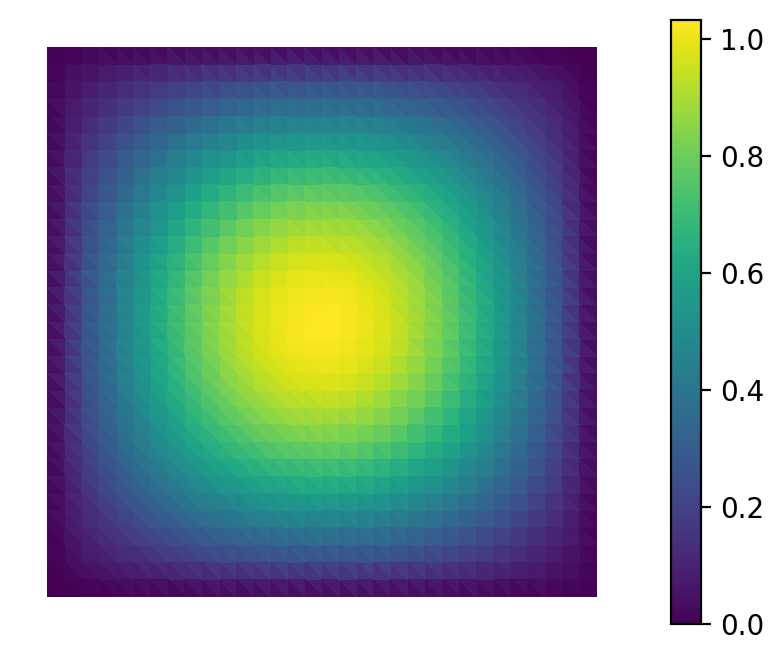

In [115]:
plot(basis, whp2, colorbar=True)

In [25]:
def solve_problem1(m):

    element = {'w': ElementTriP1(), 'u': ElementTriMorley()}
    basis = {
        variable: InteriorBasis(m, e, intorder=4)
        for variable, e in element.items()
    }  # intorder: integration order for quadrature

    K1 = asm(laplace, basis['w'])
    f1 = asm(f_load, basis['w'])

    wh = solve(*condense(K1, f1, D=m.boundary_nodes()),
               solver=solver_iter_krylov(Precondition=True, tol=1e-8))

#     K2 = epsilon**2 * asm(a_load, basis['u']) + asm(b_load, basis['u'])
#     f2 = asm(wv_load, basis['w'], basis['u']) * wh
#     uh0 = solve(*condense(K2, f2, D=easy_boundary(basis['u'])),
#                 solver=solver_iter_krylov(Precondition=True))  # cg
    return wh, basis

In [26]:
def solve_problem2(m):
    global fbasis
    global wh
    element = {'w': ElementTriP2(), 'u': ElementTriMorley()}
    basis = {
        variable: InteriorBasis(m, e, intorder=4)
        for variable, e in element.items()
    }

    K1 = asm(laplace, basis['w'])
    f1 = asm(f_load, basis['w'])

    wh = solve(*condense(K1, f1, D=m.boundary_nodes()),
               solver=solver_iter_krylov(Precondition=True))
    
#     fbasis = FacetBasis(m, element['u'])
    
#     p1 = asm(penalty_1, fbasis)
#     p2 = asm(penalty_2, fbasis)
#     p3 = asm(penalty_3, fbasis)
#     P = p1 + p2 + p3

#     K2 = epsilon**2 * asm(a_load, basis['u']) + epsilon**2 * P + asm(b_load, basis['u'])
#     f2 = asm(wv_load, basis['w'], basis['u']) * wh
#     uh0 = solve(*condense(K2, f2, D=easy_boundary_penalty(basis['u'])), solver=solver_iter_krylov(Precondition=True))  
#     # uh0 = solve(*condense(K2 + P, f2, D=m.boundary_nodes()), solver=solver_iter_krylov(Precondition=True)) 
    return wh, basis


### Without penalty

In [44]:
epsilon = 1e-5
ep = epsilon
m = MeshTri()

for i in range(1, 5):
    m.refine()
    element = ElementTriP1()
    basis = InteriorBasis(m, element, intorder=6)

    K1 = asm(laplace, basis)
    f1 = asm(f_load, basis)

    wh = solve(*condense(K1, f1, D=m.boundary_nodes()),
               solver=solver_iter_krylov(Precondition=True))
    
    W = basis.interpolate(wh).value

    L2u = np.sqrt(L2uError.assemble(basis, w=W))
    # Du = get_DuError(basis, wh)
    # H1u = Du + L2u
    print('L2: ', L2u)
    # print('H1: ', H1u)

L2:  0.2496217955228092
L2:  0.0790754082775316
L2:  0.021132772741605684
L2:  0.005377435115588884


In [23]:
refine_time = 5
epsilon_range = 1
for j in range(epsilon_range):
    epsilon = 1 * 10**(-j*2) * 1e-5
    ep = epsilon
    L2_list = []
    Du_list = []
    D2u_list = []
    h_list = []
    epu_list = []
    m = MeshTri()

    for i in range(1, refine_time+1):
        
        m.refine()
        uh0, basis = solve_problem1(m)
        U = basis['w'].interpolate(uh0).value

        L2u = np.sqrt(L2uError.assemble(basis['w'], w=U))
        Du = get_DuError(basis['w'], uh0)
        H1u = Du + L2u
        # D2u = get_D2uError(basis['w'], uh0)
        # H2u = Du + L2u + D2u
        epu = np.sqrt(epsilon**2 * D2u**2 + Du**2)
        h_list.append(m.param())
        Du_list.append(Du)
        L2_list.append(L2u)
        D2u_list.append(D2u)
        epu_list.append(epu)
        
#     x = basis['u'].doflocs[0]
#     y = basis['u'].doflocs[1]
#     u = exact_u(x, y)
#     plot(basis['u'], u-uh0, colorbar = True)
#     plt.show()
    
    hs = np.array(h_list)
    L2s = np.array(L2_list)
    Dus = np.array(Du_list)
    H1s = L2s + Dus
    print('epsilon =', epsilon)
    print('  h    L2u   H1u')
    for i in range(H2s.shape[0] - 1):
        print(
            '2^-' + str(i + 2), ' {:.2f}  {:.2f} '.format(
                -np.log2(L2s[i + 1] / L2s[i]), -np.log2(H1s[i + 1] / H1s[i]),
                ))
        
uh0_no_penalty = uh0

NameError: name 'D2u' is not defined

### With penalty

In [22]:
sigma = 5
epsilon_range = 4
refine_time = 4
for j in range(epsilon_range):
    epsilon = 1 * 10**(-j*2) * 1e-5
    ep = epsilon
    L2_list = []
    Du_list = []
    D2u_list = []
    h_list = []
    epu_list = []
    m = MeshTri()

    for i in range(1, refine_time+1):
        
        m.refine()
        uh0, basis = solve_problem2(m)
        U = basis['w'].interpolate(uh0).value

        L2u = np.sqrt(L2uError.assemble(basis['w'], w=U))
        Du = get_DuError(basis['w'], uh0)
        H1u = Du + L2u
        # D2u = get_D2uError(basis['w'], uh0)
        # H2u = Du + L2u + D2u
        # epu = np.sqrt(epsilon**2 * D2u**2 + Du**2)
        h_list.append(m.param())
        Du_list.append(Du)
        # L2_list.append(L2u)
        # D2u_list.append(D2u)
        # epu_list.append(epu)
        
#     x = basis['u'].doflocs[0]
#     y = basis['u'].doflocs[1]
#     u = exact_u(x, y)
#     plot(basis['u'], u-uh0, colorbar = True)
#     plt.show()
    
    hs = np.array(h_list)
    L2s = np.array(L2_list)
    Dus = np.array(Du_list)
    H1s = L2s + Dus
    print('epsilon =', epsilon)
    print('  h    L2u   H1u')
    for i in range(H2s.shape[0] - 1):
        print(
            '2^-' + str(i + 2), ' {:.2f}  {:.2f} '.format(
                -np.log2(L2s[i + 1] / L2s[i]), -np.log2(H1s[i + 1] / H1s[i]),
                ))
        
uh0_penalty = uh0

ValueError: operands could not be broadcast together with shapes (0,) (4,) 

In [133]:
wh[m.boundary_nodes()]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])